In [9]:
import pandas as pd

df = pd.read_csv("/content/Loan_default.csv")

In [10]:
df  = df.drop(["LoanID"],axis=1)


In [11]:
df.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


#Feature Engineering

###Ordinal Encoding



In [12]:
# List of categorical columns to analyze
categorical_columns = [
    'Education', 'EmploymentType', 'MaritalStatus',
    'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner'
]

# Iterate through each column and calculate the counts, percentages, and averages
for col in categorical_columns:
    print(f"\nAnalysis for {col}:\n")

    # Group by the column and 'Default', then count occurrences
    counts = df.groupby([col, 'Default']).size().unstack(fill_value=0)

    # Calculate total counts for each category
    total_counts = counts.sum(axis=1)

    # Calculate percentages of defaults and non-defaults
    percentages = (counts.div(total_counts, axis=0) * 100).round(2)

    # Add an average column for 'Default' weighted by the counts
    averages = df.groupby(col)['Default'].mean().round(2)

    # Combine counts, percentages, and averages into one table
    summary = counts.copy()
    summary['Total'] = total_counts
    summary['Default %'] = percentages[1] if 1 in percentages.columns else 0
    summary['Non-Default %'] = percentages[0] if 0 in percentages.columns else 0
    # summary['Default Rate (Average)'] = averages

    # Print the summary
    print(summary)



Analysis for Education:

Default          0     1  Total  Default %  Non-Default %
Education                                                
Bachelor's   56577  7789  64366      12.10          87.90
High School  55673  8230  63903      12.88          87.12
Master's     56633  6908  63541      10.87          89.13
PhD          56811  6726  63537      10.59          89.41

Analysis for EmploymentType:

Default             0     1  Total  Default %  Non-Default %
EmploymentType                                              
Full-time       57632  6024  63656       9.46          90.54
Part-time       56484  7677  64161      11.97          88.03
Self-employed   56404  7302  63706      11.46          88.54
Unemployed      55174  8650  63824      13.55          86.45

Analysis for MaritalStatus:

Default            0      1  Total  Default %  Non-Default %
MaritalStatus                                               
Divorced       74376  10657  85033      12.53          87.47
Married        7

Why Ordinal Encoding instead of One hot encoding


---

Based on statistical analysis, the categories in certain variables exhibit a clear order in their relationship with the target variable (Default). For example, in the "Education" variable, the default rate decreases as the education level increases (High School: 12.88%, Bachelor's: 12.10%, Master's: 10.87%, PhD: 10.59%). This trend is statistically significant, demonstrating an inherent order among the categories. By applying Ordinal Encoding, we can capture this order and utilize the progression between categories effectively, which enhances the model's ability to predict loan defaults.

In [14]:
from sklearn.preprocessing import OrdinalEncoder

# List of categorical columns to analyze
categorical_columns = [
    'Education', 'EmploymentType', 'MaritalStatus',
    'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner'
]

# Initialize an OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Dynamically generate ordinal mappings
ordinal_mappings = {}

for col in categorical_columns:
    # Group by the column and calculate the mean default rate
    default_rates = df.groupby(col)['Default'].mean().sort_values()

    # Generate the ordinal mapping dynamically based on default rates
    mapping = {category: rank for rank, category in enumerate(default_rates.index, start=1)}
    ordinal_mappings[col] = mapping

    # Apply the mapping to the column in the DataFrame
    df[col] = df[col].map(mapping)

    # print(f"Ordinal mapping for {col}: {mapping}")

# Display the first few rows of the updated DataFrame
df.head()


,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,56,85994,50587,520,80,4,15.23,36,0.44,3,1,3,1,1,2,1,0
1,69,50432,124440,458,15,1,4.81,60,0.68,2,1,1,2,2,2,1,0
2,46,84208,129188,451,26,3,21.17,24,0.31,2,4,3,1,1,4,2,1
3,32,31713,44799,743,0,3,7.07,24,0.23,4,1,1,2,2,5,2,0
4,60,20437,9139,633,8,4,6.51,48,0.73,3,4,3,2,1,4,2,0


###Train Test Split

In [17]:

from sklearn.model_selection import train_test_split

# Assuming 'Default' is your target variable
X = df.drop('Default', axis=1)
y = df['Default']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (204277, 16)
y_train shape: (204277,)
X_test shape: (51070, 16)
y_test shape: (51070,)


###Feature Scaling

In [22]:
# prompt: write code for find outliers in dataset

import pandas as pd
import numpy as np

# Assuming your data is in 'df' after the preprocessing steps

def find_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

# Example usage for a specific column (replace 'LoanAmount' with the column you want to analyze)
numerical_columns = ['LoanAmount', 'LoanTerm', 'CreditScore']
#Check if all numerical_columns are in df
for col in numerical_columns:
    if col not in df.columns:
        print(f"Warning: Column '{col}' not found in DataFrame. Skipping...")
        continue  # Skip to the next column
    outliers = find_outliers_iqr(df[col])
    print(f"Outliers in {col}: {outliers}")
    print(f"Number of outliers in {col}: {len(outliers)}")


Outliers in LoanAmount: Series([], Name: LoanAmount, dtype: int64)
Number of outliers in LoanAmount: 0
Outliers in LoanTerm: Series([], Name: LoanTerm, dtype: int64)
Number of outliers in LoanTerm: 0
Outliers in CreditScore: Series([], Name: CreditScore, dtype: int64)
Number of outliers in CreditScore: 0


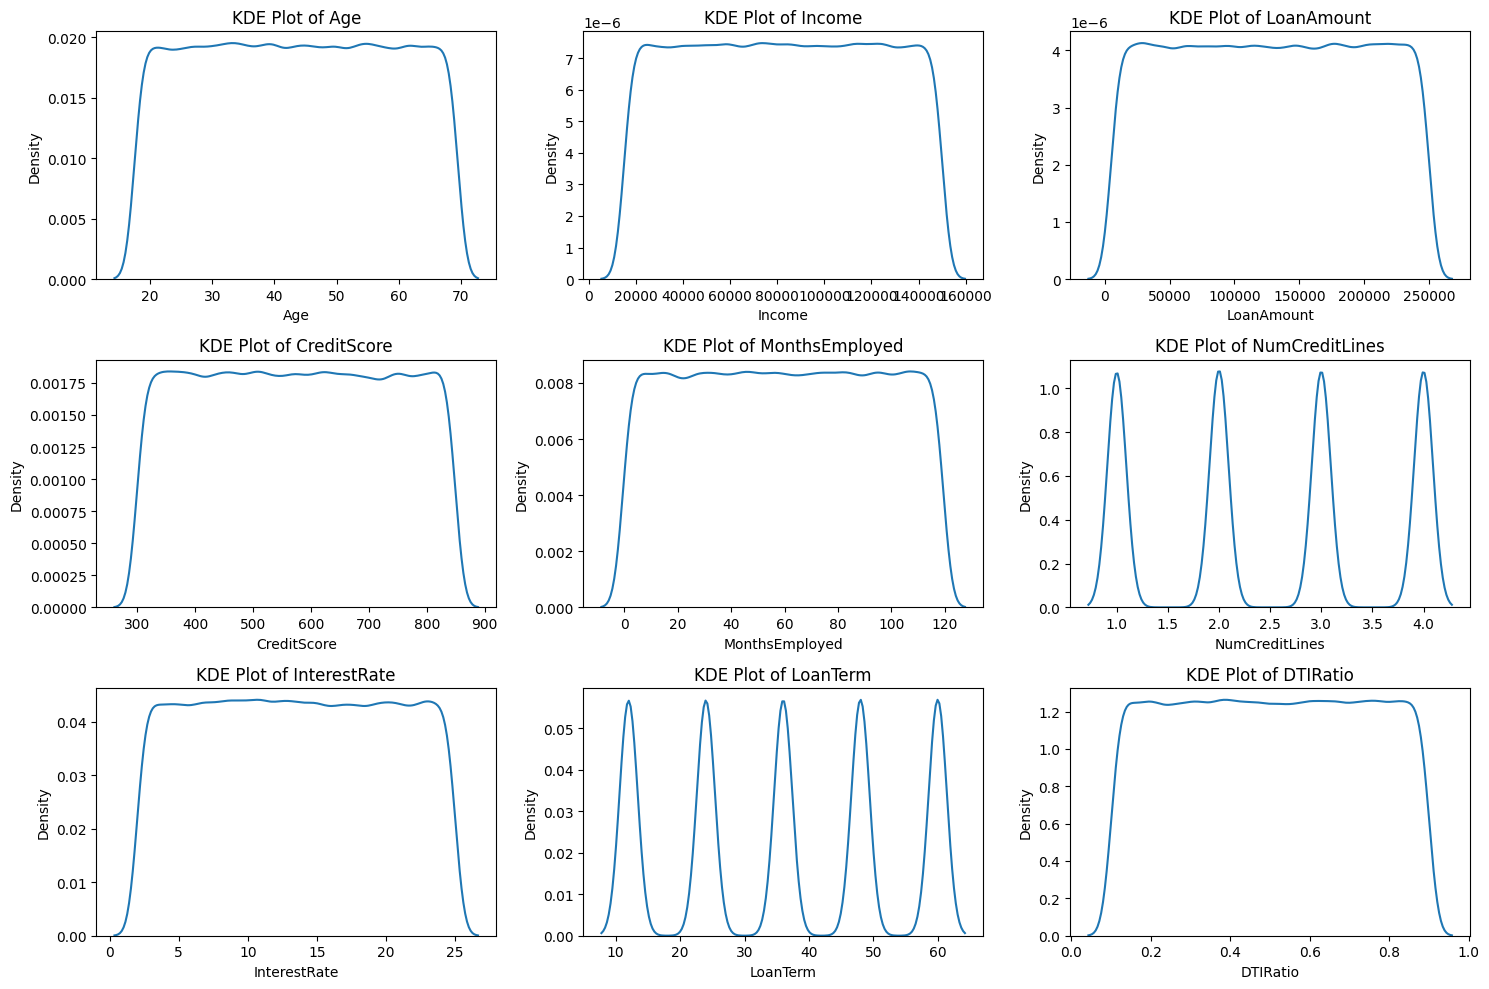

In [25]:
# prompt: plot kde of these Age	Income	LoanAmount	CreditScore	MonthsEmployed	NumCreditLines	InterestRate	LoanTerm	DTIRatio

import matplotlib.pyplot as plt
import seaborn as sns


numerical_cols = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']

# Create subplots for each numerical column
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i + 1)  # Adjust the grid layout as needed
    sns.kdeplot(df[col])
    plt.title(f'KDE Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')

plt.tight_layout()  # Adjust subplot parameters for a tight layout
plt.show()
